In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_cxr14 = pd.read_csv("/home/local/data/sophie/cxr14/train_cx14_node_21.csv")
test_cxr14 = pd.read_csv("/home/local/data/sophie/cxr14/test_cx14_node_21.csv")
train_pad = pd.read_csv("/home/local/data/sophie/padchest/train_pad_node_21.csv")
test_pad = pd.read_csv("/home/local/data/sophie/padchest/test_pad_node_21.csv")
test_openi = pd.read_csv("/home/local/data/sophie/openi/test_openi_node_21.csv")
test_jsrt = pd.read_csv("/home/local/data/sophie/jsrt/test_jsrt_node_21.csv")

In [3]:
data_df = train_cxr14.copy()
data_df['partition'] = "train"
data_df = pd.concat([data_df, test_cxr14.copy()]).fillna("test")
data_df = pd.concat([data_df, train_pad.copy()]).fillna("train")
data_df = pd.concat([data_df, test_pad.copy()]).fillna("test")
data_df = pd.concat([data_df, test_openi.copy()]).fillna("test")
data_df = pd.concat([data_df, test_jsrt.copy()]).fillna("test")

In [4]:
data_df['png'] = data_df['mha'].apply(lambda x: x[:-3]+"png")

In [5]:
data_df['label'] = data_df['label'].astype(str)

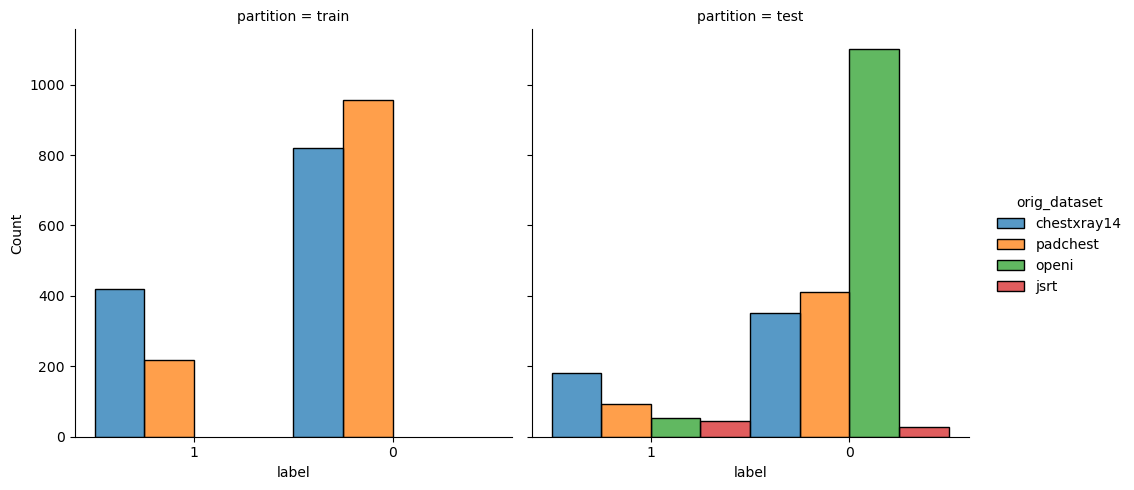

In [6]:
sns.displot(data_df, x='label',col='partition', hue='orig_dataset',multiple='dodge')

## Resampling Train & Test Distibution 

In [7]:
new_df = pd.DataFrame()
discard_df = pd.DataFrame()
for dataset in data_df.orig_dataset.unique():
    if len(data_df.query(f'orig_dataset == "{dataset}"').partition.unique())>1:
        for partition in data_df.query(f'orig_dataset == "{dataset}"').partition.unique():
            samples = data_df.query(f'orig_dataset == "{dataset}" & partition == "{partition}"').copy()
            vc = samples.label.value_counts()
            majority_label = vc.index[0]
            num_samples_to_remove = vc.iloc[0]-vc.iloc[1]
            maj_sample = samples.query(f"label=='{majority_label}'")[0:-num_samples_to_remove]
            new_df = pd.concat([new_df, maj_sample, samples.query(f"label=='{vc.index[1]}'") ]).reset_index(drop=True)
            discard_df = pd.concat([discard_df,samples.query(f"label=='{majority_label}'")[num_samples_to_remove:]]).reset_index(drop=True)
    else:
        samples = data_df.query(f'orig_dataset == "{dataset}" & partition == "test"').copy()
        vc = samples.label.value_counts()
        majority_label = vc.index[0]
        num_samples_to_remove = vc.iloc[0]-vc.iloc[1]
        maj_sample = samples.query(f"label=='{majority_label}'")[0:-num_samples_to_remove]
        new_df = pd.concat([new_df, maj_sample, samples.query(f"label=='{vc.index[1]}'") ]).reset_index(drop=True)
        discard_df = pd.concat([discard_df,samples.query(f"label=='{majority_label}'")[num_samples_to_remove:]]).reset_index(drop=True)
        

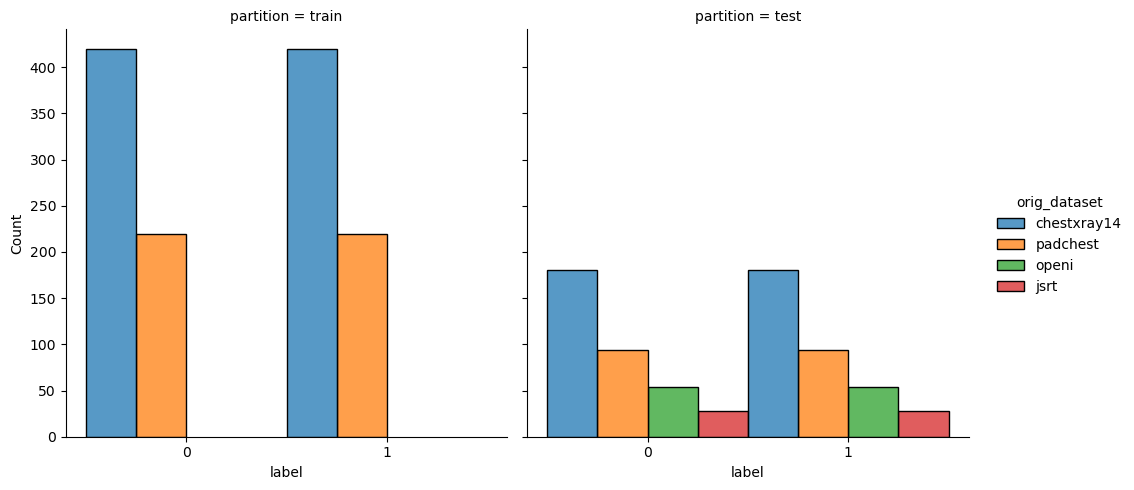

In [33]:
sns.displot(new_df, x='label',col='partition', hue='orig_dataset',multiple='dodge')

In [9]:
discard_df.head()

,original_image_name,orig_dataset,label,mha,Finding Labels,Patient ID,Patient Age,Patient Gender,original_image_width,original_image_height,...,Manufacturer,Modality,subtlety,nodule_size,malignant,shared_image_area,Dim_bin,partition,filename,png
0,00001177_000,chestxray14,0,c1617.mha,No Finding,1177,60.0,M,2992.0,2991.0,...,test,test,test,test,test,1048576.0,a,train,test,c1617.png
1,00001702_000,chestxray14,0,c1459.mha,No Finding,1702,57.0,F,2048.0,2500.0,...,test,test,test,test,test,1048576.0,a,train,test,c1459.png
2,00001261_000,chestxray14,0,c0712.mha,No Finding,1261,58.0,M,2750.0,2991.0,...,test,test,test,test,test,1048576.0,a,train,test,c0712.png
3,00001499_000,chestxray14,0,c1280.mha,No Finding,1499,48.0,F,2048.0,2500.0,...,test,test,test,test,test,1048576.0,a,train,test,c1280.png
4,00000190_000,chestxray14,0,c1063.mha,No Finding,190,29.0,M,2500.0,2048.0,...,test,test,test,test,test,1048576.0,a,train,test,c1063.png


In [29]:
discard_df['orig_dataset'].unique()

array(['chestxray14', 'padchest', 'openi', 'jsrt'], dtype=object)

In [30]:
discard_df['ds'] = discard_df['orig_dataset'].apply(lambda x: "cxr14" if x =="chestxray14" else x ) 

In [31]:
import os
base_path = "/home/local/data/sophie/node21_num_label_resample_test/"
for _, row in discard_df.iterrows():#"label","png"]]:
    os.remove(os.path.join(base_path,row.ds,"arch_seg/flat_std_1024", row.partition, "0_normal" if row.label == "0" else "1_nodule", row.png))

In [34]:
new_df.to_csv(os.path.join(base_path,"undersampled_testset_node_21.csv"))

## Oversampling Train with Undersampled Test 

In [38]:
new_df.query("partition == 'train'").orig_dataset.unique()

array(['chestxray14', 'padchest'], dtype=object)

In [39]:
new_df.query('orig_dataset == "chestxray14"').label.value_counts()

label
0    600
1    600
Name: count, dtype: int64

In [ ]:
# oversampled_df = pd.DataFrame()
# # only looking at training distributions
# for dataset in new_df.query("partition == 'train'").orig_dataset.unique():
#     samples = new_df.query(f'orig_dataset == "{dataset}"').copy()
#     vc = samples.label.value_counts()
#     minority_label = vc.index[0]
#     num_samples_to_increase = vc.iloc[0]-vc.iloc[1]
#     for partition in new_df.query(f'orig_dataset == "{dataset}"').partition.unique():
#         samples = new_df.query(f'orig_dataset == "{dataset}" & partition == "{partition}"').copy()
#         vc = samples.label.value_counts()
#         majority_label = vc.index[0]
#         num_samples_to_remove = vc.iloc[0]-vc.iloc[1]
#         maj_sample = samples.query(f"label=='{majority_label}'")[0:-num_samples_to_remove]
#         new_df = pd.concat([new_df, maj_sample, samples.query(f"label=='{vc.index[1]}'") ]).reset_index(drop=True)
#         discard_df = pd.concat([discard_df,samples.query(f"label=='{majority_label}'")[num_samples_to_remove:]]).reset_index(drop=True)